<div style='background-image: url("https://www.geophysik.uni-muenchen.de/ROMY/theme/images/ringlaser_wideformat.jpg") ; padding: 0px ; background-size: cover ; border-radius: 15px ; height: 250px; background-position: 0% 80%'>
    <div style="float: left ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.9) ; width: 35% ; height: 150px">
        <div style="position: relative ; top: 50%;  transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.9) ; line-height: 100%"> <br>ROMY - <br><br>  Modulation Synthetic Chirp </div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.7)"></div>
        </div>
    </div>

## Import Libraries

### Official Libraries

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import time
import pickle

from scipy.signal import resample, hilbert, correlate, decimate
from tqdm import tqdm
from obspy import UTCDateTime, read, read_inventory, Trace

### Own Processing Methods

In [2]:
import sys
sys.path.insert(0, 'submodules')

In [26]:
from EchoPerformance import __echo_performance
from CreateSyntheticEventV2 import __create_synthetic_event_v2
from MakeplotDemodulationQuality import __makeplot_demodulation_quality
from MinimizeResidual import __minimize_residual
from CreateLinearChirp import __create_linear_chirp
from Tapering import __tapering
from InstaFreqHilbert import __insta_freq_hilbert
from Normalize import __normalize
from WriteToMseed import __write_to_mseed
from LoadMseed import __load_mseed
from Modulation import __modulation
from QuerrySeismoData import __querry_seismo_data
from Downsample import __downsample

In [4]:
from RingLaser import RingLaser

## define G-Ring
G = RingLaser(side=4., form="square", wl=632.8e-9, lat=49.16)

## define ROMY Z-Ring
ROMY_Z = RingLaser(side=11., form="triangle", wl=632.8e-9, lat=49.16)


### Own Plotting Methods

In [5]:
from MakeplotTraceAndSpectrum import __makeplot_trace_and_spectrum
from MakeplotTraceAndPSD import __makeplot_trace_and_psd
from MakeplotModulatedSignal import __makeplot_modulated_signal

In [6]:

def __upsample_FIR(signal_in, sampling_factor, sps):
    
    from scipy.signal import upfirdn, resample_poly
    
    
    lower = 50
    upper = sampling_factor*lower
    
    signal_out = resample_poly(signal_in, upper, lower)
    
    time_out = np.arange(len(signal_out))/(sps*sampling_factor)
    
    return signal_out, time_out


In [7]:

def __interpolation(trace, time, T, sps):
    
    from scipy.signal import resample
    from numpy import arange
    
    ## interpolate modeltrace to sps 
    l1 = trace.size
    
    trace = resample(trace, int(T*sps+1))
#     time = resample(time, int(T*sps+1))    
    
    l2 = trace.size
    
    print(f"modeltrace is interpolated: {l1} samples --> {l2} samples")
#     print(f"time_modeltrace is interpolated: {l1} samples --> {l2} samples")

    time = arange(0, T+1/sps, 1/sps)

    return trace, time


## Configurations

In [8]:
config = {}

## time period
config['T'] = 1600  ## seconds

## samles per second
config['sps'] = 5000

config['Npts'] = int(config['T']*config['sps'])
print(f"Total Samples: {config['Npts']}")


config['sgnc'] = round(ROMY_Z.get_sagnac_frequency(), 2)
print(f"Rounded Sagnac Frequency: {round(config['sgnc'], 2)} Hz")

config['modulation_index'] = ROMY_Z.get_scale_factor()
print(f"Modulation Index (scale factor): {config['modulation_index']}")

config['modulation_scheme'] = 3


## decide if oversampling is set (bool) and how much oversampling
config['oversampling'] = True
config['oversampling_factor'] = 4

Total Samples: 8000000
Rounded Sagnac Frequency: 553.67 Hz
Modulation Index (scale factor): 10036114.034585783


## Get Synthetic Signal

/home/andbro/anaconda3/envs/obs/lib/python3.7/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (1.0) of bandpass is at or above Nyquist (0.5). Applying a high-pass instead.
  warnings.warn(msg)


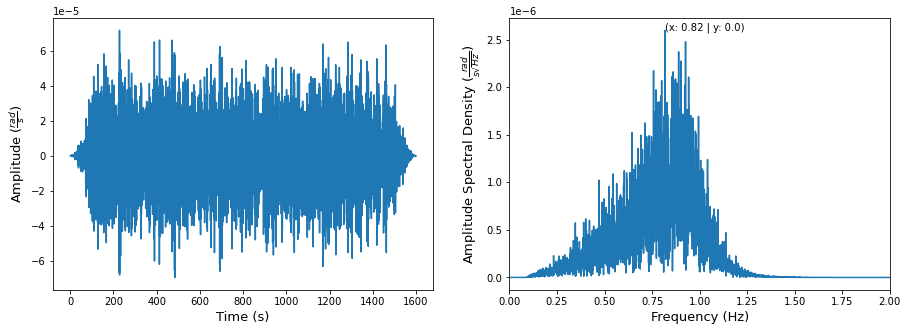

In [9]:
config['f_lower'], config['f_upper'] = 0.1, 1.0

## load genereated synthetic broadband trace
syn0 = read("./data/SYN_T1600_fs5000_f0.001-20.0.mseed")

## taper to avoid edge effects
syn0.taper(0.1, 'hann')

## fitler to adjust frequency band
syn0.filter('bandpass', freqmin=config['f_lower'], freqmax=config['f_upper'], corners=8, zerophase=True)

## extract data as array
modeltrace = syn0[0].data; del syn0

## make time axis
time_modeltrace = np.arange(0, config['T']+1/config['sps'], 1/config['sps'])

## plot the trace and amplitude spectrum
__makeplot_trace_and_spectrum(modeltrace, time_modeltrace, fmax=2*config['f_upper']); 

## Upsample the signal

In [10]:
if config['oversampling']:
    
    ## upsample using a FIR filter
#     modeltrace, time_modeltrace = __upsample_FIR(modeltrace, oversampling_factor, sps)

    ## upsample using interpolation method
    modeltrace, time_modeltrace = __interpolation(modeltrace, time_modeltrace, config['T'], config['oversampling_factor']*config['sps'])
    
    ## adjust sps value
    config['sps'] *= config['oversampling_factor']

## check length of arrays
modeltrace.size, time_modeltrace.size

modeltrace is interpolated: 8000001 samples --> 32000001 samples


(32000001, 32000001)

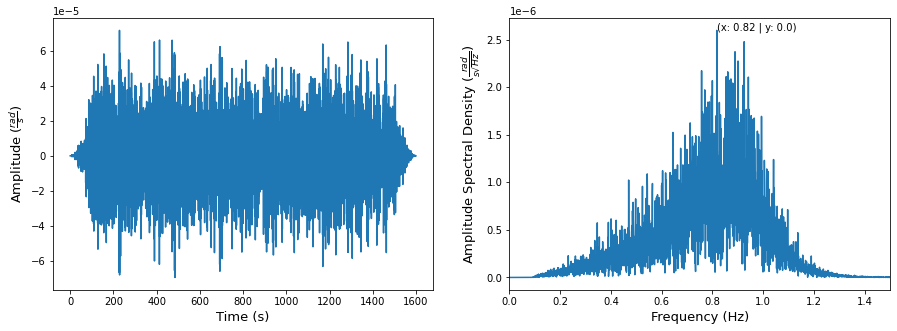

In [11]:
__makeplot_trace_and_spectrum(modeltrace, time_modeltrace, fmax=1.5*config['f_upper']); 

# Modulation

In [12]:

synthetic_signal, timeline = __modulation(
                                          modeltrace,
                                          time_modeltrace, 
                                          config['sgnc'], 
                                          config['T'], 
                                          config['sps'], 
                                          config['modulation_index'], 
                                          config['modulation_scheme'],
                                         )



Modulation option 3 is executed ...

 --> integrating ... 

 elapsed time: 11.37 sec


### Taper

In [13]:
# synthetic_signal = __tapering(synthetic_signal, taper_type='hann', percent=0.2)

### Plots

-553.6 0.00422377201339


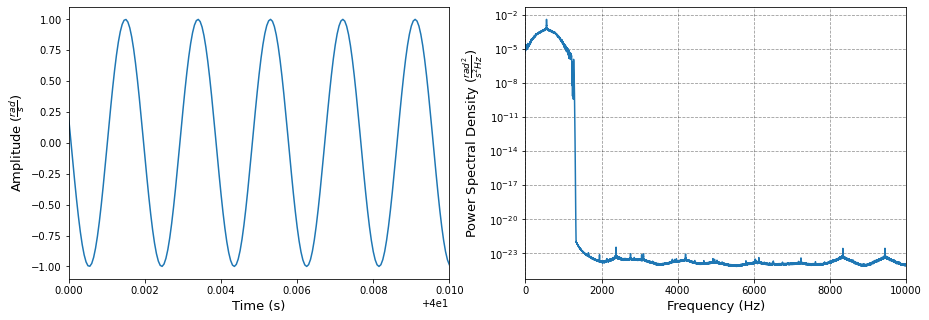

In [14]:
__makeplot_trace_and_psd(synthetic_signal, timeline, fmax=0.5*config['sps'], t1=40, t2=40.01);

-553.6 0.00422377201339


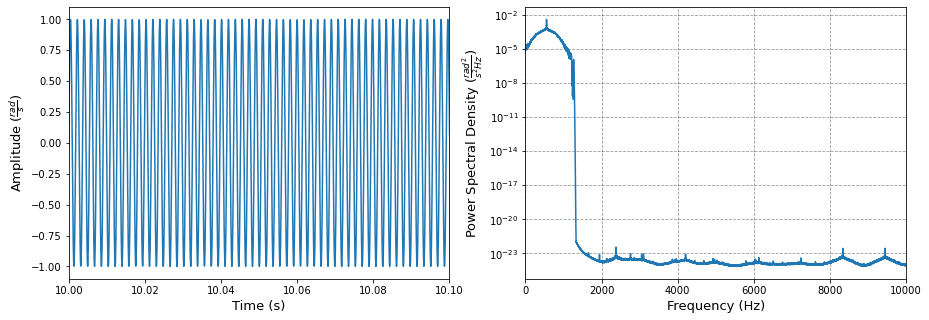

In [15]:
__makeplot_trace_and_psd(synthetic_signal, timeline, fmax=0.5*config['sps'], t1=10, t2=10.1); 

## Downsample

The modulation has been performed with an oversampling factor to avoid erros. Now the result is resampled mimicing the real sampling of the analog signal.

In [22]:
synthetic_signal.size, modeltrace.size

(32000001, 32000001)

In [23]:
if config['oversampling']:

    sps0 = config['sps'] ## prevent overwriting
    synthetic_signal, timeline, config['sps'] = __downsample(synthetic_signal, sps0, ds_factor=config['oversampling_factor'])
    modeltrace, time_modeltrace, config['sps'] = __downsample(modeltrace, sps0, ds_factor=config['oversampling_factor'])


synthetic_signal.size, modeltrace.size

(8000001, 8000001)

-552.75 0.00232837046583


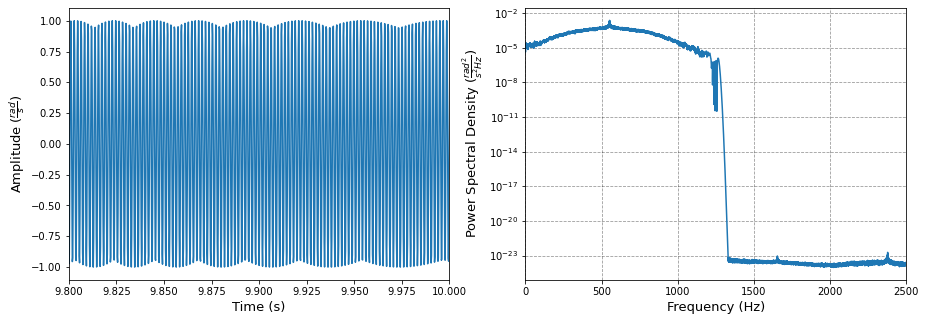

In [25]:
__makeplot_trace_and_psd(synthetic_signal, timeline, fmax=0.5*config['sps'], t1=9.8, t2=10); 

## Write 

In [ ]:
# config['outpath'] = "/home/andbro/notebooks/Sagnac_processing/data/"

# config['oname'] = "chirp"

## store modulated trace 
# ofile = open(f"{config['outpath']}{config['oname']}.syn","wb")
# pickle.dump(synthetic_signal, ofile)
# ofile.close()

## store modeltrace
# ofile = open(f"{config['outpath']}{config['oname']}.mod","wb")
# pickle.dump(modeltrace, ofile)
# ofile.close()

## store configurations
# ofile = open(f"{config['outpath']}{config['oname']}.conf","wb")
# pickle.dump(config, ofile)
# ofile.close()